Random Forest algorithm for Machine Failure estimation

In [38]:
import pandas as pd

df = pd.read_csv('Data/workdata.csv')
df = df.iloc[:, 2:-5]  # Disregard the first two and the last five columns which are noise
#df = df.iloc[:,6]
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,L,298.9,309.1,2861,4.6,143,1
1,L,298.9,309.0,1410,65.7,191,1
2,L,298.8,308.9,1455,41.3,208,1
3,L,298.4,308.2,1282,60.7,216,1
4,L,298.3,308.1,1412,52.3,218,1


In [39]:
df['Machine failure'].value_counts()

Machine failure
0    1200
1     339
Name: count, dtype: int64

In [40]:
from sklearn.model_selection import train_test_split

x = df.drop(['Type','Machine failure'], axis=1) # Disregard the machine failure column
y = df['Machine failure']  # The target variable

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

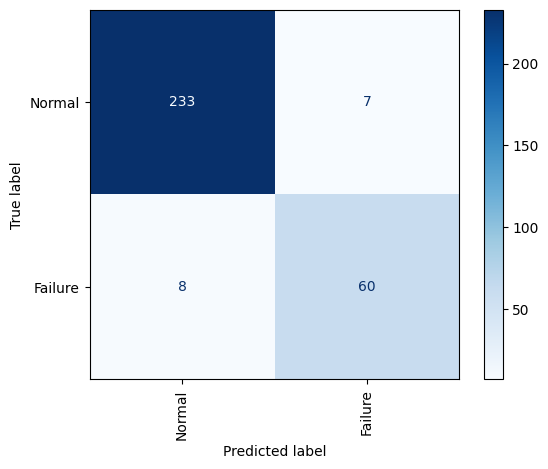

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay as cmd




rf_model = RandomForestClassifier(n_estimators=100, max_features=None, random_state=42)
rf_model.fit(X_train, y_train)



labels = ['Normal', 'Failure']
cmd.from_estimator(rf_model, X_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

In [42]:
y_pred = rf_model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9512987012987013
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       240
           1       0.90      0.88      0.89        68

    accuracy                           0.95       308
   macro avg       0.93      0.93      0.93       308
weighted avg       0.95      0.95      0.95       308



In [43]:
from sklearn.model_selection import GridSearchCV

#param_grid = {
#    'n_estimators': [75, 100, 150],
#    'max_depth': [None, 10, 20],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'criterion': ['gini', 'entropy'],
#    'max_features': ['sqrt', None]
#}

#grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='recall')
#grid_search.fit(X_train, y_train)

#print(f"Best Parameters: {grid_search.best_params_}")

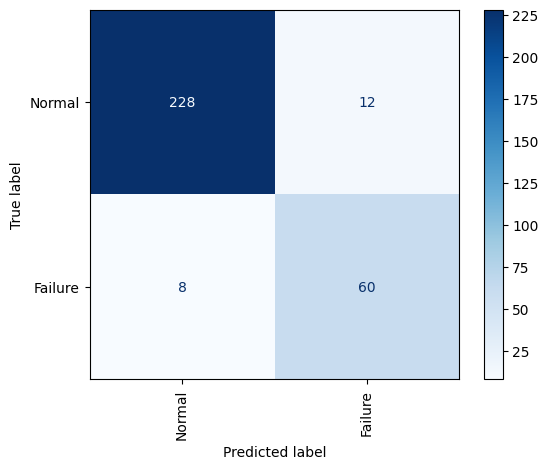

In [113]:
rf_model = RandomForestClassifier(max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100, class_weight={0: 1, 1: 4}, random_state=42)
rf_model.fit(X_train, y_train)



labels = ['Normal', 'Failure']
cmd.from_estimator(rf_model, X_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

Accuracy: 0.8928571428571429
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       240
           1       0.68      0.97      0.80        68

    accuracy                           0.89       308
   macro avg       0.84      0.92      0.86       308
weighted avg       0.92      0.89      0.90       308



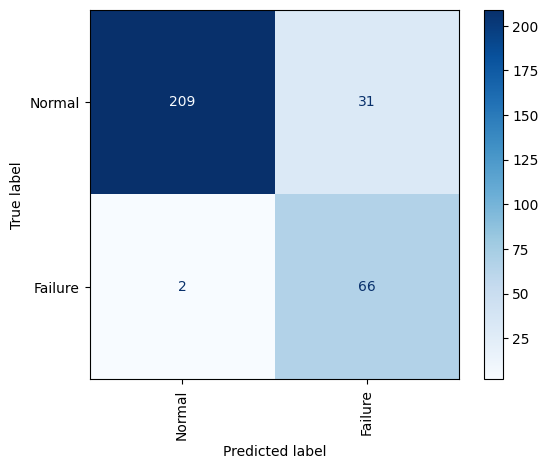

In [122]:
proba = rf_model.predict_proba(X_test)[:, 1]
threshold = 0.1
y_pred = (proba >= threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

cmd.from_predictions(y_test, y_pred, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

As we can see we achieve a decent result with random forest, especially when the custom threshold is placed on the system achieving 0.97 recall on machine failure

Lets try with Logistic regression and see if that performs better

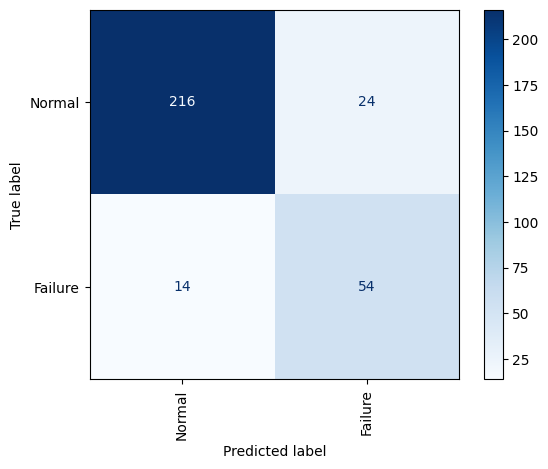

In [46]:
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=42, max_iter=100, class_weight={0: 1, 1: 3})
lr_model.fit(X_train, y_train)

cmd.from_estimator(lr_model, X_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

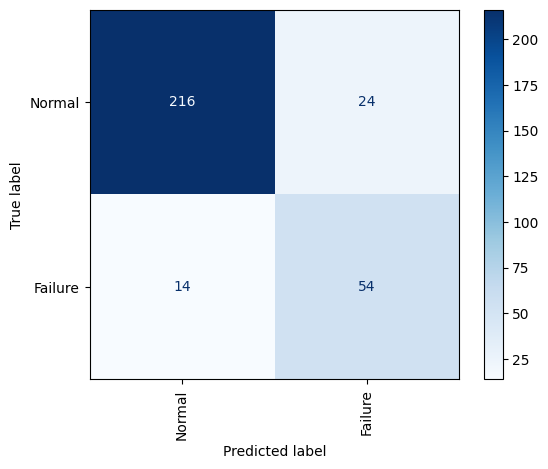

In [91]:
lr_model = LogisticRegression(random_state=42, max_iter=500, class_weight={0: 1, 1: 3})
lr_model.fit(X_train, y_train)

cmd.from_estimator(lr_model, X_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')
# Evaluate the model



Accuracy: 0.8084415584415584
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.86       240
           1       0.54      0.91      0.68        68

    accuracy                           0.81       308
   macro avg       0.75      0.85      0.77       308
weighted avg       0.87      0.81      0.82       308



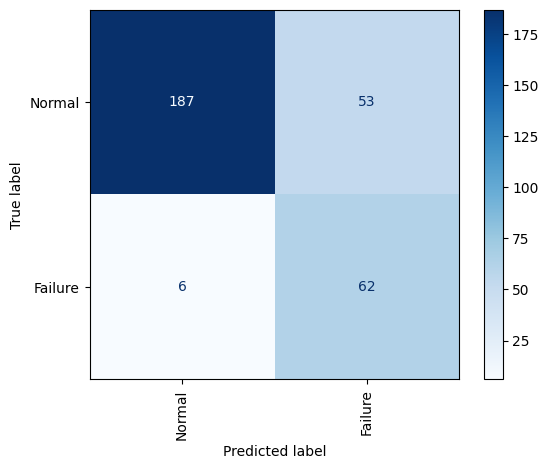

In [95]:


proba = lr_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
threshold = 0.3
predictions = (proba >= threshold).astype(int)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, predictions))

cmd.from_predictions(y_test, predictions, display_labels=labels, cmap='Blues', xticks_rotation='vertical')



In [71]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'max_iter': [100, 500, 1000, 5000],
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced', {0: 1, 1: 10}],
}

# Use recall as the scoring metric
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    scoring='recall',
    cv=5
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

c:\Users\bayka\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\bayka\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Best Parameters: {'C': 0.01, 'class_weight': {0: 1, 1: 10}, 'max_iter': 500}
Best Recall Score: 0.9224915824915826


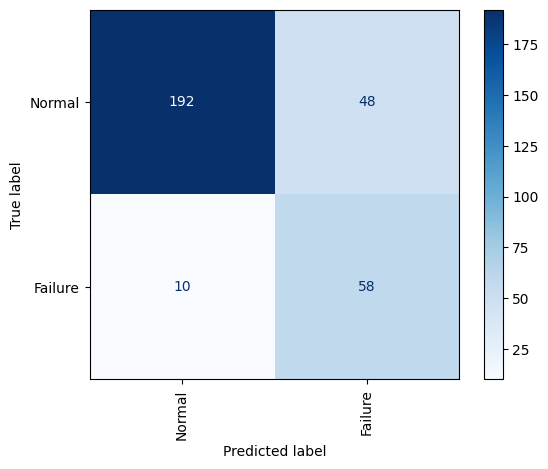

In [108]:
lr_model= LogisticRegression(C=0.01, class_weight={0:1,1:5}, max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

cmd.from_estimator(lr_model, X_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

Accuracy: 0.935064935064935
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.81       240
           1       0.46      0.91      0.61        68

    accuracy                           0.74       308
   macro avg       0.71      0.80      0.71       308
weighted avg       0.85      0.74      0.77       308



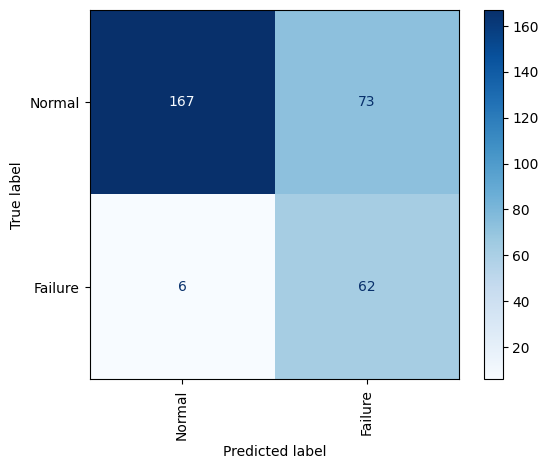

In [109]:
proba = lr_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
threshold = 0.4
predictions = (proba >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, predictions))
cmd.from_predictions(y_test, predictions, display_labels=labels, cmap='Blues', xticks_rotation='vertical')
